In [2]:
#!pip install --user pixiedust
#!pip install ggplot
#!pip install wget

In [3]:
from pixiedust.packageManager import PackageManager
pkg=PackageManager()
pkg.installPackage("graphframes:graphframes:0")
pkg.printAllPackages()

sqlContext=SQLContext(sc)

Pixiedust database opened successfully


Package already installed: graphframes:graphframes:0
graphframes:graphframes:0.5.0-spark2.1-s_2.11 => /gpfs/fs01/user/se1f-2003f1257f20bb-7f578b9e48a9/data/libs/graphframes-0.5.0-spark2.1-s_2.11.jar


# Librerias

In [4]:
from graphframes import GraphFrame
from pyspark.sql.functions import col, desc, when
from pyspark.sql import functions as F

#from ggplot import *
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import wget

# Cargamos archivos para crear grafo

Aqui cargamos los archivos de vertices y nodos, estos vienen de csv

Los vertices/nodos y aristas/relaciones son representados como dos dataframes de Spark. Mas sobre dataframes a continuacion.

En el dataframe de nodos debe existir una columna llamada `id` para designar el identificador del nodo. Igualmente, en el dataframe de relaciones deben existir columnas `src` y `dst` que denotan el origen y destino de la relacion. Estos ultimos, deben corresponder a ids validos del dataframe de nodos. 

In [5]:
nodes_file = wget.download("https://raw.githubusercontent.com/astenuz/AnalyticsForumWorkshop/master/data/trade_agro_nodes.csv")
edges_file = wget.download("https://raw.githubusercontent.com/astenuz/AnalyticsForumWorkshop/master/data/trade_agro_edges.csv")

El siguiente bloque carga los archivos csv como dataframes de spark.

In [6]:
nodes_df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(nodes_file)
    
edges_df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(edges_file)

Adicionamos un preprocesamiento simple que remueve self-loops

In [7]:
edges_df = edges_df\
  .filter(col('src') != col('dst'))

# Intro a Dataframes

Antes de continuar vamos a ver una introduccion corta a Dataframes de Spark para entender las operaciones basicas con tablas de datos que usaremos en el taller.

Un dataframe es basicamente una tabla, como de excel. Tiene columnas que interpretamos generalmente como atributos y filas que interpretamos como observaciones. Por ejemplo, veamos que hay en el dataframe de nodos.

In [10]:
nodes_df.head(5)

[Row(id='AFG', name='Afghanistan', region='South Asia'),
 Row(id='ALB', name='Albania', region='Europe'),
 Row(id='ATA', name='Antarctica', region='Other'),
 Row(id='DZA', name='Algeria', region='Middle East and North Africa'),
 Row(id='ASM', name='American Samoa', region='Oceania')]

Head selecciona los primeros 5 `Row` del dataframe, para obtener una representacion mas amigable podemos usar show o display.

In [11]:
#nodes_df.show(5)
display(nodes_df)

id,name,region
AFG,Afghanistan,South Asia
ATA,Antarctica,Other
DZA,Algeria,Middle East and North Africa
AND,Andorra,Europe
AGO,Angola,Sub-Saharan Africa
ATG,Antigua and Barbuda,Caribbean and Central America
AZE,Azerbaijan,Central and Northern Asia
BHS,Bahamas,Caribbean and Central America
ARM,Armenia,Central and Northern Asia
BEL,Belgium,Europe


Ademas de lo que acaban de ver, las operaciones que usaremos sobre dataframes en este lab son: `filter`, `select`, `withColumn`, `count`, `groupby` y `sort`

`filter` sirve para escoger filas que cumplen cierta condicion.

In [12]:
nodes_df.filter(col("Region")=='Oceania')

DataFrame[id: string, name: string, region: string]

In [13]:
nodes_df.filter(col("Region")=='Oceania').show(5)

+---+--------------------+-------+
| id|                name| region|
+---+--------------------+-------+
|ASM|      American Samoa|Oceania|
|AUS|           Australia|Oceania|
|BVT|       Bouvet Island|Oceania|
|IOT|British Indian Oc...|Oceania|
|SLB|        Solomon Isds|Oceania|
+---+--------------------+-------+
only showing top 5 rows



Para escoger columnas, usamos `select`

In [14]:
nodes_df.select("name").show(5)

+--------------+
|          name|
+--------------+
|   Afghanistan|
|       Albania|
|    Antarctica|
|       Algeria|
|American Samoa|
+--------------+
only showing top 5 rows



Tambien podemos agregar columnas utilizando `withColumn`.

In [15]:
edges_df\
    .withColumn("weight_mas_1", col("weight")+1)\
    .show(5)

+---+---+--------------------+----------+----------+------------+
|src|dst|            resource|     value|    weight|weight_mas_1|
+---+---+--------------------+----------+----------+------------+
|AFG|DZA|        Horticulture|    26.313|         3|         4.0|
|AFG|DZA|     Rubber and gums|     1.507|     0.585|       1.585|
|AFG|AUS|        Horticulture|40.0930017|34.3058425|  35.3058425|
|AFG|AUS|            Oilseeds|     1.248|      0.46|        1.46|
|AFG|AUS|Stimulants, tobac...|    34.645|      0.02|        1.02|
+---+---+--------------------+----------+----------+------------+
only showing top 5 rows



Varias veces vamos a contar resultados usando `groupby` y `count`

In [16]:
nodes_df\
    .groupby("region").count()\
    .show()

+--------------------+-----+
|              region|count|
+--------------------+-----+
|          South Asia|    8|
|Middle East and N...|   20|
|              Europe|   43|
|  Sub-Saharan Africa|   50|
|               China|    3|
|               Other|    4|
|       North America|    5|
|East Asia excludi...|    3|
|       South America|   13|
|Caribbean and Cen...|   31|
|             Oceania|   30|
|Central and North...|   12|
|      Southeast Asia|   11|
+--------------------+-----+



In [17]:
#una variante
#note que esto permite contar ocurrencias de otras columnas dentro del grupo, 
#tambien debemos agregar el alias a la columna para que no quede nombrada como 'count(region)'
nodes_df\
    .groupby("region")\
    .agg(F.count("region").alias("count"))\
    .show()

+--------------------+-----+
|              region|count|
+--------------------+-----+
|          South Asia|    8|
|Middle East and N...|   20|
|              Europe|   43|
|  Sub-Saharan Africa|   50|
|               China|    3|
|               Other|    4|
|       North America|    5|
|East Asia excludi...|    3|
|       South America|   13|
|Caribbean and Cen...|   31|
|             Oceania|   30|
|Central and North...|   12|
|      Southeast Asia|   11|
+--------------------+-----+



`sort` permite ordenar valores, el orden por defecto es ascendente pero podemos invertirlo con `desc`

In [18]:
nodes_df\
    .groupby("region").count()\
    .sort(desc("count"))\
    .show()

+--------------------+-----+
|              region|count|
+--------------------+-----+
|  Sub-Saharan Africa|   50|
|              Europe|   43|
|Caribbean and Cen...|   31|
|             Oceania|   30|
|Middle East and N...|   20|
|       South America|   13|
|Central and North...|   12|
|      Southeast Asia|   11|
|          South Asia|    8|
|       North America|    5|
|               Other|    4|
|               China|    3|
|East Asia excludi...|    3|
+--------------------+-----+



Despues de todo esto, al fin podemos proseguir con los grafos.

# Grafos

GraphFrame permite crear el grafo

In [19]:
g = GraphFrame(nodes_df, edges_df)
print(g)

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 3 more fields])


Atributos del grafo `g` como nodos y relaciones son Dataframes, asi que todo lo que vimos en la anterior seccion puede ser aplicado sobre los atributos `.vertices` y `.edges`. 

In [20]:
display(g.vertices)

#g.vertices.describe().show()

id,name,region
DZA,Algeria,Middle East and North Africa
ASM,American Samoa,Oceania
AGO,Angola,Sub-Saharan Africa
ATG,Antigua and Barbuda,Caribbean and Central America
AUS,Australia,Oceania
AUT,Austria,Europe
BHS,Bahamas,Caribbean and Central America
BGD,Bangladesh,South Asia
BRB,Barbados,Caribbean and Central America
BEL,Belgium,Europe


Este grafo tiene demadiadas aristas, mostramos solo las primeras 10.

In [21]:
g.edges.count()

102374

In [22]:
g.edges.show(10)

+---+---+--------------------+----------+----------+
|src|dst|            resource|     value|    weight|
+---+---+--------------------+----------+----------+
|AFG|DZA|        Horticulture|    26.313|         3|
|AFG|DZA|     Rubber and gums|     1.507|     0.585|
|AFG|AUS|        Horticulture|40.0930017|34.3058425|
|AFG|AUS|            Oilseeds|     1.248|      0.46|
|AFG|AUS|Stimulants, tobac...|    34.645|      0.02|
|AFG|BHR|Dairy, eggs, and ...|      0.02|      0.02|
|AFG|BHR|        Horticulture|   105.007|    62.036|
|AFG|BHR|              Pulses|    14.976|     14.69|
|AFG|BHR|Stimulants, tobac...|    110.66|     0.297|
|AFG|BGD|Stimulants, tobac...|   133.438|    65.411|
+---+---+--------------------+----------+----------+
only showing top 10 rows



In [23]:
g.edges.describe().show()

+-------+------+------+--------+------------------+------------------+
|summary|   src|   dst|resource|             value|            weight|
+-------+------+------+--------+------------------+------------------+
|  count|102374|102374|  102374|            102374|            102374|
|   mean|  null|  null|    null|11068.544232002812|  20521.1480371849|
| stddev|  null|  null|    null|112718.61277887148|1972509.6577426852|
|    min|   ABW|   ABW| Cereals|             0.001|             0.001|
|    max|   ZWE|   ZWE|   Water|                NA|                NA|
+-------+------+------+--------+------------------+------------------+



podemos tambien mostrar el grafo. Recuerde cambiar el tipo de grafico a Directed Graph (con el icono que parece un share)

In [24]:
#display(g)

Usaremos tambien un grafo mas pequenho de ejemplo sobre el cual podremos ejecutar los algoritmos mas pesados sin problema

In [25]:
vertices = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)], ["id", "name", "age"])

edges = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("d", "e", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

toy_g = GraphFrame(vertices, edges)
display(toy_g)

# Que podemos saber de este grafo?

## Pattern matching

De una manera muy similar a Neo4j podemos hacer queries sobre el grafo. En GraphFrames queries son llamadas motifs.

In [112]:
#Ejemplos de pattern matching

Por ejemplo, encontremos todos los nodos que tienen relaciones bilaterales.

In [113]:
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
#display(motifs) #display con motif tiene problemas en bluemix, por eso usamos show, o take, o head.
motifs.show(10)

+--------------------+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|                  e2|
+--------------------+--------------------+--------------------+--------------------+
|[AFG,Afghanistan,...|[AFG,AUS,Horticul...|[AUS,Australia,Oc...|[AUS,AFG,Other ag...|
|[AFG,Afghanistan,...|[AFG,AUS,Horticul...|[AUS,Australia,Oc...|[AUS,AFG,Meat,583...|
|[AFG,Afghanistan,...|[AFG,AUS,Oilseeds...|[AUS,Australia,Oc...|[AUS,AFG,Other ag...|
|[AFG,Afghanistan,...|[AFG,AUS,Oilseeds...|[AUS,Australia,Oc...|[AUS,AFG,Meat,583...|
|[AFG,Afghanistan,...|[AFG,AUS,Stimulan...|[AUS,Australia,Oc...|[AUS,AFG,Other ag...|
|[AFG,Afghanistan,...|[AFG,AUS,Stimulan...|[AUS,Australia,Oc...|[AUS,AFG,Meat,583...|
|[AFG,Afghanistan,...|[AFG,BHR,Dairy, e...|[BHR,Bahrain,Midd...|[BHR,AFG,Dairy, e...|
|[AFG,Afghanistan,...|[AFG,BHR,Horticul...|[BHR,Bahrain,Midd...|[BHR,AFG,Dairy, e...|
|[AFG,Afghanistan,...|[AFG,BHR,Pulses,1...|[BHR,Bahrai

Note que nodos en a y b se encuentre repetidos ya que un registro aparece tantas veces como haya relaciones `e` y `e2` que satisfagan la condicion. Puede listar los paises mejor eliminando duplicados.

In [114]:
motifs.count() #con combinaciones de paises repetidos

735102

In [115]:
bilaterals = motifs.selectExpr("a.name as aName","b.name as bName").dropDuplicates().sort(['aName', 'bName']) #solo seleccionamos los nombres con selectExpr
#display(bilaterals)
bilaterals.count() #eliminamos duplicados

14651

In [116]:
bilaterals.show(20)

+-----------+----------+
|      aName|     bName|
+-----------+----------+
|Afghanistan| Australia|
|Afghanistan|   Bahrain|
|Afghanistan|Bangladesh|
|Afghanistan|   Belgium|
|Afghanistan|    Brazil|
|Afghanistan|  Bulgaria|
|Afghanistan|    Canada|
|Afghanistan|     China|
|Afghanistan|Czech Rep.|
|Afghanistan|   Denmark|
|Afghanistan|     Egypt|
|Afghanistan|   Finland|
|Afghanistan|    France|
|Afghanistan|   Germany|
|Afghanistan|   Hungary|
|Afghanistan|     India|
|Afghanistan| Indonesia|
|Afghanistan|      Iran|
|Afghanistan|     Italy|
|Afghanistan|     Japan|
+-----------+----------+
only showing top 20 rows



Seleccionamos el grafo que corresponde a nodos de paises latinoamericanos, codificado en la columna `region` del nodo como `South America`.

In [117]:
#paths = g.find("(a)-[e]->(b)")\
#  .filter("a.region = 'South America' and b.region = 'South America'")\
#  .filter("e.resource = 'Pearls and gemstones'")
  

paths = g.find("(a)-[e]->(b)")\
  .filter("a.region = 'South America' and b.region = 'South America'")

In [118]:
paths.show(10)

+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|
+--------------------+--------------------+--------------------+
|[ARG,Argentina,So...|[ARG,ARG,Cereals,...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Dairy, e...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Fish and...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Horticul...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Live ani...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Meat,536...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Oilseeds...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Other ag...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Pulses,3...|[ARG,Argentina,So...|
|[ARG,Argentina,So...|[ARG,ARG,Roots an...|[ARG,Argentina,So...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [119]:
latam_edges = paths \
    .selectExpr("e.src as src", "e.dst as dst", "e.resource as resource")

In [120]:
latam_vertices = g.vertices.filter("region = 'South America'")

In [121]:
latam_g = GraphFrame(latam_vertices, latam_edges)

In [122]:
latam_g.vertices.count()

13

In [123]:
latam_g.edges.count()

921

In [124]:
display(latam_g)

Otro mas, vamos a quedarnos con paises que tengan movimientos con peso mayor a la media en carne

In [125]:
media_peso = 20000

In [126]:
big_edges = g.edges.filter(col("weight") >= media_peso).filter(col("resource")== "Meat")

In [127]:
big_edges.count()

323

In [128]:
big_g = GraphFrame(g.vertices, e = big_edges)

In [ ]:
display(big_g)

En capacidades de pattern matching GraphFrames y GraphX resulta mas complicado y menos intuitivo que Neo4j, especialmente porque ver resultados como un grafo requiere construir otro. Sin embargo, el core de GraphFrames y GraphX es procesamiento y algoritmos avanzados sobre grafos a gran escala.

## Degree distribution

Grados de entrada. Podemos interpretarlo como que tanto importan los paises

In [ ]:
display(g.inDegrees.sort(desc("inDegree")))

Grados de salida, Interpretamos como que tanto exportan los paises

In [ ]:
display(g.outDegrees.sort(desc("outDegree")))

Claro, tambien tenemos la distribucion global.

In [ ]:
display(g.degrees.sort(desc("degree")))

Todos estos resultados son simplemente tablas (DataFrames). Podemos graficarlos.

In [133]:
degree_dist = g.degrees.toPandas()\
    .sort_values(['degree'], ascending = False).reset_index(drop=True)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


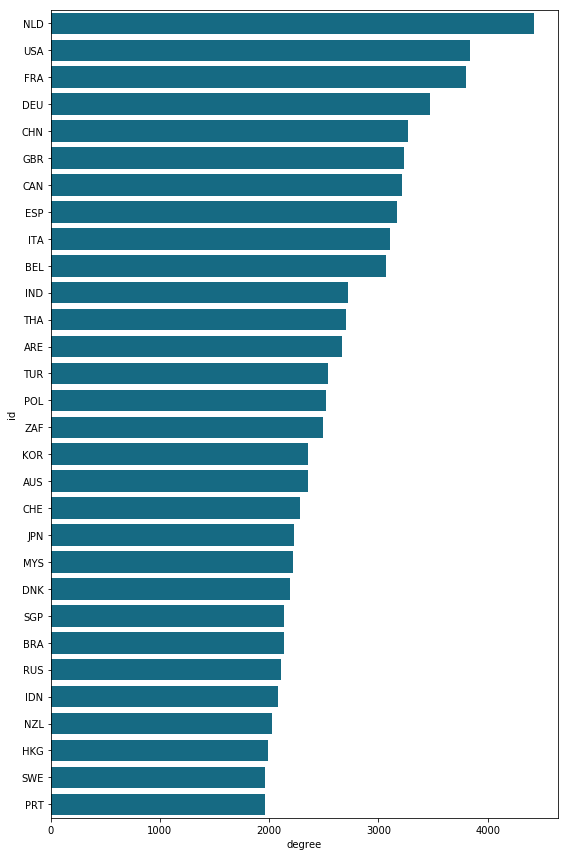

In [134]:
plt.figure(figsize=(8,12))
sns.barplot(x = 'degree', y= 'id', data = degree_dist.head(30), color='xkcd:sea blue')
plt.tight_layout()
plt.show()


## BFS

Breadth First Search es un tipo de busqueda en grafos que parte de un nodo inicial y busca el camino mas corto hacia un nodo que cumpla cierta condicion. En `toy_g` por ejemplo, buscamos el camino mas corto desde `'David'` a nodos que tengan mas de 30 anhos.

In [153]:
paths = toy_g.bfs("name = 'David'", "age > 30")

paths.show()

+------------+------------+-------------+
|        from|          e0|           to|
+------------+------------+-------------+
|[d,David,29]|[d,e,friend]|[e,Esther,32]|
|[d,David,29]|[d,a,friend]| [a,Alice,34]|
+------------+------------+-------------+



En el dataset del mundo, siendo colombia queremos ver que posibles caminos de exportacion llevan a paises del sureste de asia, `Southeast Asia`.

In [154]:
col_paths = g.bfs(
  fromExpr = "name = 'Colombia'", #expresion que define el/los nodos de salida
  toExpr = "region = 'Europe'", #Expresion que define los nodos de llegada
  #edgeFilter = "resource = 'Cereals'", #un filtro para los ejes
  maxPathLength = 4) #maxima longitud del camino

col_paths.count()

223

In [155]:
col_paths.select("e0").take(5)

[Row(e0=Row(src='COL', dst='ALB', resource='Horticulture', value='1794.27132', weight='2517.43357')),
 Row(e0=Row(src='COL', dst='ALB', resource='Stimulants, tobacco, spices', value='184.338613', weight='56.6779464')),
 Row(e0=Row(src='COL', dst='AUT', resource='Fish and aquatic resources', value='8.883', weight='0.79')),
 Row(e0=Row(src='COL', dst='AUT', resource='Horticulture', value='479.329', weight='76.919')),
 Row(e0=Row(src='COL', dst='AUT', resource='Live animals', value='0.2', weight='0.033'))]

## Caminos mas cortos

Podemos listar los caminos mas cortos a ciertos puntos, especificamos los nodos objetivo con el `id`

In [30]:
results = toy_g.shortestPaths(landmarks=["a", 'b', "d"])
display(results)

id,name,age,distances
g,Gabby,60,{}
b,Bob,36,{'b': 0}
e,Esther,32,"{'a': 2, 'b': 3, 'd': 1}"
a,Alice,34,"{'a': 0, 'b': 1, 'd': 2}"
f,Fanny,36,{'b': 2}
d,David,29,"{'a': 1, 'b': 2, 'd': 0}"
c,Charlie,30,{'b': 1}


## Pagerank

Este fue popularizado por Google. Es una medida de la importancia de los nodos

In [35]:
result = toy_g.pageRank(resetProbability=0.15, maxIter=5)
result.vertices.show() #devuelve otro graphframe donde los nodos tienen un atributo pageRank y las relacione sun atributo peso

+---+-------+---+-------------------+
| id|   name|age|           pagerank|
+---+-------+---+-------------------+
|  g|  Gabby| 60|               0.15|
|  b|    Bob| 36| 1.1681910439453123|
|  e| Esther| 32| 0.3962066088867187|
|  a|  Alice| 34|0.27990066064453123|
|  f|  Fanny| 36|  0.313968087890625|
|  d|  David| 29|  0.313968087890625|
|  c|Charlie| 30| 1.2648684169921873|
+---+-------+---+-------------------+



En vez de maximo de iteraciones, podemos detener el algoritmo cuando el cambio en score no supera `tol`

In [ ]:
rank = latam_g.pageRank(resetProbability=0.15, tol=0.05)

In [ ]:
display(rank.vertices.sort(desc("pagerank")))

## Comunidades

Label propagatation es un algoritmo que permite detectar comunidades en los grafos.

In [157]:
comunidades = toy_g.labelPropagation(maxIter=5)
display(comunidades)

id,name,age,label
g,Gabby,60,146028888064
b,Bob,36,1047972020224
e,Esther,32,807453851648
a,Alice,34,1382979469312
f,Fanny,36,1047972020224
d,David,29,670014898176
c,Charlie,30,1382979469312


Las aplicamos sobre el grafo `big_g`. **Toma tiempo**

In [141]:
comunidades = big_g.labelPropagation(maxIter=5)

In [142]:
display(comunidades.groupby('label').count().sort(desc('count')))

## Componentes fuertemente conectados

Un componente conectado es un grupo de nodos para los cuales existe un camino entre cualquier dos nodos del grupo.

In [ ]:
componentes = toy_g.stronglyConnectedComponents(maxIter=5)
display(componentes)

En un grafo grande tiende a tomar **mucho tiempo**

In [ ]:
componentes = big_g.stronglyConnectedComponents(maxIter=5)
display(componentes.select("id", "component"))

In [ ]:
componentes.select("id", "component").groupby("component").count().sort(desc("count")).show()

In [ ]:
#componentes.filter(col('component') == "489626271744" ).show()